In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 用途分解の計算

## 1. 概要

本ファイルは、用途分解の計算方法について記しています。  
ここで用途分解とは、家庭におけるエネルギー種別ごとの消費量つまり、消費電力、ガス消費量、灯油消費量から、家庭における用途別エネルギー消費量を推計する方法を言います。  
用途は、暖房・冷房・換気・給湯・照明・家電・調理に分類されます。
消費電力、ガス消費量、および灯油消費量は、領収書などから月単位で把握できているものとします。  
エネルギー種別の単位は以下のとおりです。  
- 消費電力  kwh
- ガス消費量  m<sup>3</sup>
- 灯油消費量  L

用途別エネルギーの推計は、エネルギー種別ごとに行います。  
電力を消費する用途としては、全ての用途が考えられます。  
ガスを消費する用途としては、暖房・給湯・調理が考えられます。  
灯油を消費する用途としては、暖房・給湯が考えられます。

用途が1つに限られている場合、例えば、灯油を暖房にしか使用していない場合などは、用途分解をするまでもなく用途が決定します。  
用途が複数にわたる場合、例えば、灯油を暖房と給湯に使用している場合などは、暖房は冬期にしか使用しないことから、灯油消費量の月別の推移を見ておおよそ暖房と給湯に分解します。  
電力の用途分解は非常に難しく、例えば電力を換気と照明に分類する場合、換気も照明も季節的な変動が見られないため、用途を分解するのは困難です。本方法では、一般的な家庭を想定した結果をデフォルト値として示しますので、家庭の事情（例えば日中照明を良く使っているなど）をヒアリングして、消費量を修正してください。

## 2. 関数

### 2.1 基本的な関数・定数

この後の関数で引用されます。

#### 1) 単位熱量のデフォルト値

|    | 換算値 | 備考 |
| :---: | :---: | :---: |
| 電気 | 1 kWh = 9.76 MJ | 省エネ基準で定められた値である。 |
| 都市ガス | 1 m3 = 45 MJ | 供給エリアによって発熱量は異なる。 |
| 灯油 | 1 L = 37 MJ | 供給エリアによって発熱量は異なる。 |
| LPG | 1 kg = 50 MJ | 供給エリアによって発熱量は異なる。 |

In [2]:
CALORIFIC_V_ELEC = 9.76
CALORIFIC_V_GAS = 45
CALORIFIC_V_KER = 37
CALORIFIC_V_LPG = 50

#### 1) 月の名前を返す関数

In [3]:
MONTH_NAMES = ['Jan', 'Feb', 'Mar', 'Apl', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

#### 2) Bool値の配列（長さ=12）を受け取りTrueの月を文字列で返す

In [4]:
def get_true_month(v):
    if len(v) != 12:
        raise ValueError('ERROR: Bool値の配列長が12ではありません。')
    str_months = [mn for (i, mn) in enumerate(MONTH_NAMES) if v[i]]
    return ', '.join(str_months)

In [5]:
get_true_month([True,True,True,True,True,True,True,True,True,True,True,True])

'Jan, Feb, Mar, Apl, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec'

#### 3) 値から全体に対する割合を出す関数

In [6]:
def get_ratio(vs):
    # vs : value, ndarray, length = 12
    
    total = vs.sum()
    return vs / total if total > 0.0 else np.zeros(12)

In [7]:
get_ratio(np.array([1,1,1,1,2,2,2,2,1,1,1,1]))

array([0.0625, 0.0625, 0.0625, 0.0625, 0.125 , 0.125 , 0.125 , 0.125 ,
       0.0625, 0.0625, 0.0625, 0.0625])

#### 4) 1月～12月までの値を辞書型でもらって表にする関数

In [8]:
def show_monthly_table(d):
    # d: 辞書型 定義の例 → {'ventilation': [1,2,3,4,5,6,7,8,9,10,11,12]}  配列の長さは必ず12にすること
    return pd.DataFrame(d, index = MONTH_NAMES).T

### 2.2 中間月（暖房月・冷房月ではない月）の取得

i. 暖房月と冷房月の長さの確認

12の配列になっているのかを確認します。

ii. 同じ月に暖房使用月と冷房使用月が同時に発生していないことの確認

同じ月に暖房使用月と冷房使用月が同時に発生した場合、用途分解が不可能なため、エラーとしてはじくことにします。

iii. 中間期の取得

暖房月でも冷房月でもない月を中間月とします。

In [9]:
def get_intermediate_month(htg_use, clg_use):
    
    if len(htg_use) != 12:
        raise ValueError('ERROR: 暖房の使用の有無が12ヶ月分ありません。')
    
    if len(clg_use) != 12:
        raise ValueError('ERROR: 冷房の使用の有無が12ヶ月分ありません。')
    
    for i, (h, c) in enumerate(zip(htg_use, clg_use)):
        if h and c:
            raise ValueError('エラー：同じ月に暖房使用月と冷房使用月は同時に設定できません。(' + str(i) + '月)' ) 
    
    return [h == False and c == False for (h,c) in zip(htg_use, clg_use)]

In [10]:
show_monthly_table({'is intermediate month ?':
                    get_intermediate_month(htg_use = [True, True, True, False, False, False, False, False, False, False, True, True],
                                           clg_use = [False, False, False, False, False, False, True, True, True, False, False, False])})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
is intermediate month ?,False,False,False,True,True,True,False,False,False,True,False,False


### 2.3. 暖冷房・給湯以外の用途のエネルギー消費量の推計（仮決め）

これらの値は省エネルギー基準の設計一次エネルギー消費量の計算方法に準拠して計算した値をもとに決められています。

#### 1) 換気

以下の条件で計算しました。

- 換気設備の種類: 壁付け式第三種換気設備
- 比消費電力: 0.3
- 換気回数, 1/h: 0.5
- 床面積の合計, m<sup>3</sup>: 120.0
- 省エネルギー対策の有無: 比消費電力を入力することにより省エネルギー効果を評価する
- 有効換気量率: 指定の必要なし

計算の結果、全般換気のE消費量は4062.85(MJ)となり、この値を120.0 m<sup>2</sup> で除した値が、約33.9 MJ/m<sup>2</sup>です。  
局所換気の場合は人数に依存するため、1人～4人まで計算して下記の値が得られました。

- 1人: 130 MJ
- 2人: 259 MJ
- 3人: 389 MJ
- 4人: 518 MJ

換気の消費量の月別割合は、全般換気の値を月ごとに割合で示したものです。局所換気の値は無視します。

| 1月 | 2月 | 3月 | 4月 | 5月 | 6月 | 7月 | 8月 | 9月 | 10月 | 11月 | 12月 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 8.5% | 7.7% | 8.5% | 8.2% | 8.5% | 8.2% | 8.5% | 8.5% | 8.2% | 8.5% | 8.2% | 8.5% |


In [11]:
def get_std_consumption_for_ventilation(p, fa_total, coeff):
    # p : number of people (person)
    # fa_total : total floor area (m2)
    # coeff : coefficient for ventilation
    
    # general ventilation
    c = 33.9 # MJ/m2 a
    general = c * fa_total # MJ/a
    
    # local ventilation
    local = {1 : 130.0, 2 : 259.0, 3 : 389.0, 4 : 518.0}[p] # MJ/a
    
    # divide to montly consumption
    month_ratios = np.array([8.5, 7.7, 8.5, 8.2, 8.5, 8.2, 8.5, 8.5, 8.2, 8.5, 8.2, 8.5])

    return month_ratios / 100 * (general + local) * coeff

In [12]:
show_monthly_table({'ventilation': list(map(int, get_std_consumption_for_ventilation(p=4, fa_total=120.08, coeff=1.0))) })

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
ventilation,390,353,390,376,390,376,390,390,376,390,376,390


#### 2) 照明

居住人数を1,2,3,4人、面積を0,10,20,30,40 m<sup>2</sup>と変化させて、以下の条件で計算しました。

- 主たる居室：蛍光灯・調光なし
- その他の居室：蛍光灯・調光なし
- 非居室：蛍光灯・人感センサーなし

消費量は面積と線形の関係になるために、居住人数・部屋用途ごとに、

$y = a \cdot x + b$

の形で傾きと切片を計算しました。

月別の割合は、デフォルトの面積において計算した値（主たる居室・その他の居室・非居室を合計したもの）から算出した結果、パーセント表記で小数点以下1桁に四捨五入して丸めたところ以下のとおりとなりました。

| 1月 | 2月 | 3月 | 4月 | 5月 | 6月 | 7月 | 8月 | 9月 | 10月 | 11月 | 12月 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 8.6% | 7.7% | 8.6% | 8.2% | 8.3% | 8.2% | 8.7% | 8.5% | 8.2% | 8.4% | 8.4% | 8.4% |

この合計が四捨五入の関係上100%にならないため、以下の操作を行いました。

- 1月: 8.6% -> 8.5%
- 3月: 8.6% -> 8.5%


In [13]:
def get_std_consumption_for_lighting(p, fa_mr, fa_or, fa_total, coeff):
    # p : number of people, person
    # fa_mr : floor area of main habitable room, m2
    # fa_or : floor area of other habitable room, m2
    # fa_total : total floor area, m2
    # coeff : coefficient for lighting
    
    # floor area of non habitable room, m2
    fa_nr = fa_total - fa_mr - fa_or
    
    a_mr, b_mr = {
        1: (28.4,  417.2),
        2: (58.0,  885.8),
        3: (65.7, 1002.3),
        4: (73.5, 1118.9)
    }[p]
    
    a_or, b_or = {
        1: ( 1.7,  38.5),
        2: ( 3.3,  78.0),
        3: (15.8, 432.1),
        4: (28.2, 786.2)
    }[p]

    a_nr, b_nr = {
        1: ( 3.2, 193.0),
        2: ( 7.8, 458.0),
        3: ( 9.7, 580.0),
        4: (11.6, 701.0)
    }[p]

    # annual primary energy consumption, MJ/a
    c_mr = a_mr * fa_mr + b_mr
    c_or = a_or * fa_or + b_or
    c_nr = a_nr * fa_nr + b_nr
    
    # divide to montly consumption
    month_ratios = np.array([8.5, 7.7, 8.5, 8.2, 8.3, 8.2, 8.7, 8.5, 8.2, 8.4, 8.4, 8.4])
    
    return month_ratios / 100 * (c_mr + c_or + c_nr) * coeff

In [14]:
show_monthly_table({'lighting': list(map(int, get_std_consumption_for_lighting(p=4, fa_mr=29.81, fa_or=54.34, fa_total=120.08, coeff=1.0))) })

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
lighting,573,519,573,553,559,553,586,573,553,566,566,566


#### 3) 家電

居住人数を変化させて計算しました。

月別の割合は、デフォルトの面積において計算した値（主たる居室・その他の居室・非居室を合計したもの）から算出した結果、パーセント表記で小数点以下1桁に四捨五入して丸めたところ以下のとおりとなりました。

| 1月 | 2月 | 3月 | 4月 | 5月 | 6月 | 7月 | 8月 | 9月 | 10月 | 11月 | 12月 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 8.5% | 7.7% | 8.5% | 8.2% | 8.4% | 8.2% | 8.6% | 8.5% | 8.2% | 8.5% | 8.3% | 8.5% |

この合計が四捨五入の関係上100%にならないため、以下の操作を行いました。

- 12月: 8.5% -> 8.4%


In [15]:
def get_std_consumption_for_electric_appliance(p, coeff):
    # p : number of people, person
    # coeff : coefficient fo electric appliances
    
    anual = {1:9965.0, 2:12086.0, 3:16523.0, 4:17388}[p]
    
    month_ratios = np.array([8.5, 7.7, 8.5, 8.2, 8.3, 8.2, 8.7, 8.5, 8.2, 8.4, 8.4, 8.4])
    
    return month_ratios / 100 * anual * coeff

In [16]:
show_monthly_table({'electric appliances': list(map(int, get_std_consumption_for_electric_appliance(p=4, coeff=1.0))) })

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
electric appliances,1477,1338,1477,1425,1443,1425,1512,1477,1425,1460,1460,1460


#### 4) 調理

居住人数を変化させて計算しました。

月別の割合は、デフォルトの面積において計算した値（主たる居室・その他の居室・非居室を合計したもの）から算出した結果、パーセント表記で小数点以下1桁に四捨五入して丸めたところ以下のとおりとなりました。

| 1月 | 2月 | 3月 | 4月 | 5月 | 6月 | 7月 | 8月 | 9月 | 10月 | 11月 | 12月 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 8.6% | 7.7% | 8.6% | 8.1% | 8.1% | 8.3% | 8.6% | 8.6% | 8.1% | 8.4% | 8.3% | 8.4% |


この合計が四捨五入の関係上100%にならないため、以下の操作を行いました。

- 2月: 7.7% -> 7.8%
- 6月: 8.3% -> 8.4%


In [17]:
def get_std_consumption_for_cooking(p, coeff):
    # p : number of people, person
    # coeff : coefficient for cooking
    
    anual = {1:2217.0, 2:2724.0, 3:3288.0, 4:3852}[p]
    
    month_ratios = np.array([8.6, 7.8, 8.6, 8.1, 8.1, 8.4, 8.6, 8.6, 8.1, 8.4, 8.3, 8.4])
    
    return month_ratios / 100 * anual * coeff

In [18]:
show_monthly_table({'cooking': list(map(int, get_std_consumption_for_cooking(p=4, coeff=1.0))) })

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
cooking,331,300,331,312,312,323,331,331,312,323,319,323


#### 5) 暖冷房・給湯以外の消費量

1)～4)で計算する、暖冷房・給湯以外の消費量をまとめて返す関数を作成します。

In [19]:
def get_std_consumption(p, fa_mr, fa_or, fa_total,
                        vnt_coeff, ltg_coeff, eap_coeff, ckg_coeff,
                        vnt_use, ltg_use, eap_use, ckg_use):
    # p : number of people, person
    # fa_mr : floor area of main habitable room, m2
    # fa_or : floor area of other habitable room, m2
    # fa_total : total floor area, m2
    # vnt_coeff, ltg_coeff, eap_coeff, ckg_coeff
    #     : coefficient for ventilation, lighting, electric appliances, cooking
    # vnt_use, ltg_use, eap_use, ckg_use
    #     : use for ventilation, lighting, electric appliances, cooking
    
    # for ventilation
    if vnt_use:
        vnt = get_std_consumption_for_ventilation(p, fa_total, vnt_coeff)
    else:
        vnt = np.zeros(12)
    
    # for lighting
    if ltg_use:
        ltg = get_std_consumption_for_lighting(p, fa_mr, fa_or, fa_total, ltg_coeff)
    else:
        ltg = np.zeros(12)

    # for electric appliances
    if eap_use:
        eap = get_std_consumption_for_electric_appliance(p, eap_coeff)
    else:
        eap = np.zeros(12)
    
    # for cooking
    if ckg_use:
        ckg = get_std_consumption_for_cooking(p, ckg_coeff)
    else:
        ckg = np.zeros(12)
    
    total = vnt + ltg + eap + ckg

    return vnt, ltg, eap, ckg, total

In [20]:
vnt, ltg, eap, ckg, total = get_std_consumption(4, 29.81, 54.34, 120.08, 1.0, 1.0, 1.0, 1.0, True, True, True, True)

show_monthly_table({
    'ventilation': list(map(int,vnt)),
    'lighting': list(map(int,ltg)),
    'electric appliances': list(map(int,eap)),
    'cooking': list(map(int,ckg)),
    'total': list(map(int,total))
})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
ventilation,390,353,390,376,390,376,390,390,376,390,376,390
lighting,573,519,573,553,559,553,586,573,553,566,566,566
electric appliances,1477,1338,1477,1425,1443,1425,1512,1477,1425,1460,1460,1460
cooking,331,300,331,312,312,323,331,331,312,323,319,323
total,2772,2512,2772,2667,2705,2678,2820,2772,2667,2740,2723,2740


### 2.4 暖冷房・給湯以外の用途が月別消費量を超えていないかどうかを確認し暖冷房・給湯の月別消費量を取得（給湯使用がある場合のみ）

In [21]:
def get_h_c_hws_value(total_std, cons):
    # total_std : monthly primary energy consumption for the usage excepting heating, cooling and hot water supply, MJ/month
    # cons : monthly totla primary energy consumption, MJ/month
    # type : ndarray, length = 12

    def check(i, s, c):
        if s > c:
            raise ValueError('ERROR: 暖冷房・給湯以外の用途が月消費量を超えています。(' + str(i) + '月)' )
    
    # 暖冷房・給湯以外の用途が月別消費量を超えていないかどうかを確認
    [check(i,s,c) for (i, (s,c)) in enumerate(zip(total_std, cons))]
    
    return cons - total_std

### 2.5 給湯消費量の月別割合（給湯使用がある場合のみ）

月別の給湯消費量割合です。1月あたりの日数が違うことと、給湯負荷は給湯消費量が同じ場合でも市水の温度に依存して給湯熱量が変動することから、各月でばらつきが生じます。一般的に市水温度が低い冬季には給湯エネルギー消費量は高く、市水温度が高い夏季には給湯エネルギー消費量は低くなります。

In [22]:
def get_hws_ratio():
    return np.array([
        0.113029483482984,
        0.103264264682528,
        0.108322913038195,
        0.0884022587794812,
        0.0750187062626471,
        0.0653395455302283,
        0.0616377958319547,
        0.0519224042745101,
        0.0597337741598062,
        0.0772954737578718,
        0.0922799475117598,
        0.103753432688034
    ])

### 2.6 暖冷房・給湯に使用していない月の消費割合と消費量から月消費量を求める

暖房も冷房も使用していない月がある場合（複数可）は、その月の暖冷房・給湯消費量の合計(a)（暖冷房に使用していない暖冷房・給湯消費量、つまり必然的に給湯消費量そのものになる）とその月の給湯割合の合計(b)を求めます。  
給湯の年間消費量はa÷bで求めることができます。  
暖房も冷房も使用していない月がない場合は、暖冷房＋給湯エネルギー消費量が最も少ない月の消費量(c)とその月の給湯割合(d)から、給湯の年間消費量を、c÷dで求めることにします。本来であれば(c)の値の中には暖冷房エネルギー消費量が含まれているため、この方法は若干給湯消費量を多く見積もることになります。  
求めた給湯の年間消費量を元に以下の操作を行います。  
- 中間月の場合は暖冷房の消費エネルギーが無い、つまり必然的に使用用途は給湯に限られるため、消費量を給湯消費量として見ます。
- 上記以外の場合は、年間給湯消費量に月別の給湯消費量割合を乗じることで、暖冷房・給湯消費量を超える範囲で、月ごとの給湯消費量を求めます。


In [23]:
def get_monthly_value(ratio, middle_month, cons):
    # ratio : ration of monthly energy consumption, ndarray, length = 12
    # middle_month : is the month the middle month ? True or False, ndarray, length = 12
    # cons : monthle energy consumption, MJ/month, ndarray, length = 12
    
    
    if True in middle_month: # 中間期月がある場合、中間期月の割合とエネルギーを合計する
        middle_month_index = np.where(middle_month) # 中間月のindexを抽出
        sum_cons = sum(cons[middle_month_index]) # 抽出されたindexに基づき消費量を合算
        sum_ratio = sum(ratio[middle_month_index]) # 抽出されたindexに基づき給湯消費割合を合算
        
    else: # 中間期月がない場合、cons の最小値を採用し、その月のratioを採用する
        sum_cons = min(cons)
        sum_ratio = ratio[np.argmin(cons)]
    
    annual_cons = 0.0 if sum_ratio == 0.0 else sum_cons / sum_ratio
    
    def get_monthly(m,c,r,ac):
        if m:
            return c
        else:
            return min(c, ac*r)
    
    return [get_monthly(m,c,r,annual_cons) for (m,c,r) in zip(middle_month, cons, ratio)]

In [24]:
list(map(int,
get_monthly_value(np.array([0.085, 0.077, 0.085, 0.082, 0.083, 0.082, 0.087, 0.085, 0.082, 0.084, 0.084, 0.084]),
                  np.array([False, False, False, False, False, False, False, False, False, True, False, False]),
                  np.array([7519.0, 6810.0, 6588.0, 4422.0, 3791.0, 4032.0, 5420.0, 5458.0, 4212.0, 3774.0, 4661.0, 6705.0]))
))

[3818, 3459, 3818, 3684, 3729, 3684, 3908, 3818, 3684, 3774, 3774, 3774]

### 2.7 暖冷房消費量を求める（給湯使用がある場合のみ）

In [25]:
def get_h_w(heating_use, cooling_use, h_c_hws, hws):
    heating = [c-n if u else 0.0 for (c,n,u) in zip(h_c_hws, hws, heating_use)]
    cooling = [c-n if u else 0.0 for (c,n,u) in zip(h_c_hws, hws, cooling_use)]
    return heating, cooling

### 2.8 全用途の消費量（給湯使用がない場合のみ）

In [26]:
def get_all_use(htg_use, clg_use, cons, v_l_e_c,
                vnt_prv, lgt_prv, eap_prv, ckg_prv, v_l_e_c_prv):
    
    htg = [c-n if u else 0.0 for (c,n,u) in zip(cons, v_l_e_c, htg_use)]
    clg = [c-n if u else 0.0 for (c,n,u) in zip(cons, v_l_e_c, clg_use)]
    hws = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    vnt = [0.0 if s==0.0 else n*v/s for (n,v,s) in zip(v_l_e_c, vnt_prv, v_l_e_c_prv)]
    ltg = [0.0 if s==0.0 else n*l/s for (n,l,s) in zip(v_l_e_c, lgt_prv, v_l_e_c_prv)]
    eap = [0.0 if s==0.0 else n*e/s for (n,e,s) in zip(v_l_e_c, eap_prv, v_l_e_c_prv)]
    ckg = [0.0 if s==0.0 else n*c/s for (n,c,s) in zip(v_l_e_c, ckg_prv, v_l_e_c_prv)]
    
    return htg, clg, hws, vnt, ltg, eap, ckg

In [27]:
htg, clg, hws, vnt, ltg, eap, ckg \
    = get_all_use([True, True, True, True, False, False, False, False, False, False, True, True],
            [False, False, False, False, True, True, True, True, True, False, False, False],
            [7519.0, 6810.0, 6588.0, 4422.0, 3791.0, 4032.0, 5420.0, 5458.0, 4212.0, 3774.0, 4661.0, 6705.0],
            [3817.0, 3459.0, 3817.0, 3672.0, 3724.0, 3688.0, 3884.0, 3817.0, 3672.0, 3774.0, 3749.0, 3774.0],
            [390.04052, 353.330824, 390.04052, 376.274384, 390.04052, 376.274384, 390.04052, 390.04052, 376.274384, 390.04052, 376.274384, 390.04052],
            [573.436435, 519.465947, 573.436435, 553.197502, 559.943813, 553.197502, 586.929057, 573.436435, 553.197502, 566.690124, 566.690124, 566.690124],
            [1477.98, 1338.876, 1477.98, 1425.816, 1443.204, 1425.816, 1512.756, 1477.98, 1425.816, 1460.592, 1460.592, 1460.592],
            [331.272, 300.456, 331.272, 312.012, 312.012, 323.568, 331.272, 331.272, 312.012, 323.568, 319.716, 323.568],
            [2772.728955, 2512.128771, 2772.728955, 2667.299886, 2705.200333, 2678.855886, 2820.997577, 2772.728955, 2667.299886, 2740.890644, 2723.272508, 2740.890644])
show_monthly_table({
    'heating': list(map(int, htg)),
    'cooling': list(map(int, clg)),
    'hot water supply': list(map(int, hws)),
    'ventilation': list(map(int, vnt)),
    'lighting': list(map(int, ltg)),
    'electric appliances': list(map(int, eap)),
    'cooking': list(map(int, ckg))
})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
heating,3702,3351,2771,750,0,0,0,0,0,0,912,2931
cooling,0,0,0,0,67,344,1536,1641,540,0,0,0
hot water supply,0,0,0,0,0,0,0,0,0,0,0,0
ventilation,536,486,536,518,536,518,537,536,518,537,517,537
lighting,789,715,789,761,770,761,808,789,761,780,780,780
electric appliances,2034,1843,2034,1962,1986,1962,2082,2034,1962,2011,2010,2011
cooking,456,413,456,429,429,445,456,456,429,445,440,445


## 3. 各関数の使い方の解説

### Ex.1 電気を全ての用途に使用する場合（中間月がある場合）

用途別の消費電力の実際（正解値）(kWh)は下記のようであったとします。下記の値を合計値から推定するのが用途分解です。

|      | Jan | Feb | Mar | Apl | May | Jun | Jly | Aug | Spt | Oct | Nov | Dec |
| ---- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 暖房 | 321 | 296 | 233 |  52 |   0 |   0 |   0 |   0 |   0 |   0 |  73 | 254 |
| 冷房 |   0 |   0 |   0 |   0 |   1 |  52 | 191 | 210 |  82 |   0 |   0 |   0 |
| 給湯 | 165 | 146 | 157 | 125 | 108 |  87 |  77 |  66 |  78 | 105 | 127 | 151 |
| 換気 |  40 |  36 |  40 |  39 |  40 |  39 |  40 |  40 |  39 |  40 |  39 |  40 |
| 照明 |  59 |  53 |  59 |  57 |  57 |  57 |  60 |  58 |  56 |  58 |  58 |  58 |
| 家電 | 152 | 137 | 152 | 147 | 150 | 146 | 153 | 151 | 145 | 151 | 148 | 151 |
| 調理 |  34 |  31 |  34 |  33 |  32 |  33 |  34 |  34 |  32 |  33 |  33 |  33 |


In [28]:
ex1_htg_real_kWh = np.array([321, 296, 233,  52,   0,   0,   0,   0,   0,   0,  73, 254])
ex1_clg_real_kWh = np.array([  0,   0,   0,   0,   1,  52, 191, 210,  82,   0,   0,   0])
ex1_hws_real_kWh = np.array([165, 146, 157, 125, 108,  87,  77,  66,  78, 105, 127, 151])
ex1_vnt_real_kWh = np.array([ 40,  36,  40,  39,  40,  39,  40,  40,  39,  40,  39,  40])
ex1_ltg_real_kWh = np.array([ 59,  53,  59,  57,  57,  57,  60,  58,  56,  58,  58,  58])
ex1_eap_real_kWh = np.array([152, 137, 152, 147, 150, 146, 153, 151, 145, 151, 148, 151])
ex1_ckg_real_kWh = np.array([ 34,  31,  34,  33,  32,  33,  34,  34,  32,  33,  33,  33])

この時の消費電力（合計）(kWh)は以下のようになります。

In [29]:
ex1_cons_kWh = ex1_htg_real_kWh + ex1_clg_real_kWh + ex1_hws_real_kWh + ex1_vnt_real_kWh + ex1_ltg_real_kWh + ex1_eap_real_kWh + ex1_ckg_real_kWh
show_monthly_table({'Total': ex1_cons_kWh})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Total,771,699,675,453,388,414,555,559,432,387,478,687


これ以降の計算は一次エネルギーベースで議論するため、単位換算をしておきます。  
換算係数は省エネ基準に準拠して、9.76 MJ/kWh です。

In [30]:
ex1_cons = ex1_cons_kWh * CALORIFIC_V_ELEC
show_monthly_table({'Total': list(map(int,ex1_cons))})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Total,7524,6822,6588,4421,3786,4040,5416,5455,4216,3777,4665,6705


暖房の使用月は以下のようになります。

In [31]:
ex1_htg_use = [c > 0 for c in ex1_htg_real_kWh]
show_monthly_table({'use for heating': ex1_htg_use})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
use for heating,True,True,True,True,False,False,False,False,False,False,True,True


冷房の使用月は以下のようになります。

In [32]:
ex1_clg_use = [c > 0 for c in ex1_clg_real_kWh]
show_monthly_table({'use for cooling': ex1_clg_use})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
use for cooling,False,False,False,False,True,True,True,True,True,False,False,False


暖房にも冷房にも使用していない月を特定します。全ての月が暖房にも冷房にも使用されている場合の判断方法については後述します。

In [33]:
ex1_itm_month = get_intermediate_month(ex1_htg_use, ex1_clg_use)
show_monthly_table({'not use for heating or cooling': ex1_itm_month})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
not use for heating or cooling,False,False,False,False,False,False,False,False,False,True,False,False


暖冷房・給湯以外の用途（換気・照明・家電・調理）の一次エネルギー消費量を計算します。ここでは以下の想定で計算します。  

- 家族人数：4人
- 主たる居室の面積：29.81(m2)
- その他の居室の面積：54.34(m2)
- 床面積の合計：120.08(m2)
- 調整係数は全て1.0

※ここで、調整係数とは、換気・照明・家電・調理・給湯のエネルギー消費量を増減させる係数です。暖房と冷房は月のエネルギー消費量の推移からおおよその値を予測しますが、月変動がほとんど無い換気・照明・家電・調理・給湯などは、省エネ基準における計算に基づいておおよその割合で割り振っています。ヒアリング等を通じて居住者の住まい方を調査し、極端に照明が多い、風呂に給湯はほとんど使用しない等、特殊なケースが見られる場合は、この調整係数の値を変更してください。（通常は1.0を使用します。）

In [34]:
ex1_vnt_prv, ex1_ltg_prv, ex1_eap_prv, ex1_ckg_prv, ex1_v_l_e_c_prv \
    = get_std_consumption(p=4, fa_mr=29.81, fa_or=54.34, fa_total=120.08,
                          vnt_coeff=1.0, ltg_coeff=1.0, eap_coeff=1.0, ckg_coeff=1.0,
                          vnt_use=True, ltg_use=True, eap_use=True, ckg_use=True)
show_monthly_table({
    'ventilation': list(map(int,ex1_vnt_prv)),
    'lighting': list(map(int,ex1_ltg_prv)),
    'electric appliances': list(map(int,ex1_eap_prv)),
    'cooking': list(map(int,ex1_ckg_prv)),
    'total': list(map(int,ex1_v_l_e_c_prv))
})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
ventilation,390,353,390,376,390,376,390,390,376,390,376,390
lighting,573,519,573,553,559,553,586,573,553,566,566,566
electric appliances,1477,1338,1477,1425,1443,1425,1512,1477,1425,1460,1460,1460
cooking,331,300,331,312,312,323,331,331,312,323,319,323
total,2772,2512,2772,2667,2705,2678,2820,2772,2667,2740,2723,2740


全体のエネルギー消費量から暖冷房・給湯を除く用途のエネルギー消費量をひくことで、暖冷房・給湯のエネルギー消費量を求めます。

In [35]:
ex1_h_c_hws = get_h_c_hws_value(ex1_v_l_e_c_prv, ex1_cons)
show_monthly_table({'heating, cooling and hot water supply': list(map(int,ex1_h_c_hws))})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
"heating, cooling and hot water supply",4752,4310,3815,1753,1081,1361,2595,2683,1549,1036,1942,3964


暖冷房・給湯のエネルギー消費量と暖冷房の使用の有無から給湯の月別消費量を求めます。

In [36]:
ex1_hws = get_monthly_value(get_hws_ratio(), ex1_itm_month, ex1_h_c_hws)
show_monthly_table({'hot water supply': list(map(int, ex1_hws))})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
hot water supply,1515,1384,1452,1185,1005,875,826,696,800,1036,1237,1390


暖冷房・給湯のエネルギー消費量と、先に求めた給湯のエネルギー消費量から、その差をとることで、暖冷房のエネルギー消費量を求めます。  
換気・照明・家電・調理は先に求めた値をそのまま使用します。

In [37]:
ex1_htg, ex1_clg = get_h_w(ex1_htg_use, ex1_clg_use, ex1_h_c_hws, ex1_hws)

ex1_vnt = ex1_vnt_prv
ex1_ltg = ex1_ltg_prv
ex1_eap = ex1_eap_prv
ex1_ckg = ex1_ckg_prv

こちらが用途分解した最終結果です。

In [38]:
show_monthly_table({
    'heating': list(map(int, ex1_htg)),
    'cooling': list(map(int, ex1_clg)),
    'hot water supply': list(map(int, ex1_hws)),
    'ventilation': list(map(int, ex1_vnt)),
    'lighting': list(map(int, ex1_ltg)),
    'electric appliances': list(map(int, ex1_eap)),
    'cooking': list(map(int, ex1_ckg))
})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
heating,3236,2925,2363,568,0,0,0,0,0,0,704,2573
cooling,0,0,0,0,75,485,1769,1987,748,0,0,0
hot water supply,1515,1384,1452,1185,1005,875,826,696,800,1036,1237,1390
ventilation,390,353,390,376,390,376,390,390,376,390,376,390
lighting,573,519,573,553,559,553,586,573,553,566,566,566
electric appliances,1477,1338,1477,1425,1443,1425,1512,1477,1425,1460,1460,1460
cooking,331,300,331,312,312,323,331,331,312,323,319,323


こちらが元の値（一次エネ換算済み）です。

In [39]:
show_monthly_table({
    'heating': list(map(int, ex1_htg_real_kWh * CALORIFIC_V_ELEC)),
    'cooling': list(map(int, ex1_clg_real_kWh * CALORIFIC_V_ELEC)),
    'hot water supply': list(map(int, ex1_hws_real_kWh * CALORIFIC_V_ELEC)),
    'ventilation': list(map(int, ex1_vnt_real_kWh * CALORIFIC_V_ELEC)),
    'lighting': list(map(int, ex1_ltg_real_kWh * CALORIFIC_V_ELEC)),
    'electric appliances': list(map(int, ex1_eap_real_kWh * CALORIFIC_V_ELEC)),
    'cooking': list(map(int, ex1_ckg_real_kWh * CALORIFIC_V_ELEC))
})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
heating,3132,2888,2274,507,0,0,0,0,0,0,712,2479
cooling,0,0,0,0,9,507,1864,2049,800,0,0,0
hot water supply,1610,1424,1532,1220,1054,849,751,644,761,1024,1239,1473
ventilation,390,351,390,380,390,380,390,390,380,390,380,390
lighting,575,517,575,556,556,556,585,566,546,566,566,566
electric appliances,1483,1337,1483,1434,1464,1424,1493,1473,1415,1473,1444,1473
cooking,331,302,331,322,312,322,331,331,312,322,322,322


### Ex.2 電気を全ての用途に使用する場合（中間月がない場合）

用途別の消費電力の実際（正解値）(kWh)は下記のようであったとします。Ex.1 との違いは、10月に暖房エネルギー消費がわずかにあり、中間月が無いことです。以下、Ex.1と計算方法が違う部分のみを解説します。

|      | Jan | Feb | Mar | Apl | May | Jun | Jly | Aug | Spt | Oct | Nov | Dec |
| ---- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 暖房 | 321 | 296 | 233 |  52 |   0 |   0 |   0 |   0 |   0 |   5 |  73 | 254 |
| 冷房 |   0 |   0 |   0 |   0 |   1 |  52 | 191 | 210 |  82 |   0 |   0 |   0 |
| 給湯 | 165 | 146 | 157 | 125 | 108 |  87 |  77 |  66 |  78 | 105 | 127 | 151 |
| 換気 |  40 |  36 |  40 |  39 |  40 |  39 |  40 |  40 |  39 |  40 |  39 |  40 |
| 照明 |  59 |  53 |  59 |  57 |  57 |  57 |  60 |  58 |  56 |  58 |  58 |  58 |
| 家電 | 152 | 137 | 152 | 147 | 150 | 146 | 153 | 151 | 145 | 151 | 148 | 151 |
| 調理 |  34 |  31 |  34 |  33 |  32 |  33 |  34 |  34 |  32 |  33 |  33 |  33 |

In [40]:
ex2_htg_real_kWh = np.array([321, 296, 233,  52,   0,   0,   0,   0,   0,   5,  73, 254])
ex2_clg_real_kWh = np.array([  0,   0,   0,   0,   1,  52, 191, 210,  82,   0,   0,   0])
ex2_hws_real_kWh = np.array([165, 146, 157, 125, 108,  87,  77,  66,  78, 105, 127, 151])
ex2_vnt_real_kWh = np.array([ 40,  36,  40,  39,  40,  39,  40,  40,  39,  40,  39,  40])
ex2_ltg_real_kWh = np.array([ 59,  53,  59,  57,  57,  57,  60,  58,  56,  58,  58,  58])
ex2_eap_real_kWh = np.array([152, 137, 152, 147, 150, 146, 153, 151, 145, 151, 148, 151])
ex2_ckg_real_kWh = np.array([ 34,  31,  34,  33,  32,  33,  34,  34,  32,  33,  33,  33])

In [41]:
ex2_cons_kWh = ex2_htg_real_kWh + ex2_clg_real_kWh + ex2_hws_real_kWh + ex2_vnt_real_kWh + ex2_ltg_real_kWh + ex2_eap_real_kWh + ex2_ckg_real_kWh
show_monthly_table({'Total': ex2_cons_kWh})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Total,771,699,675,453,388,414,555,559,432,392,478,687


In [42]:
ex2_cons = ex2_cons_kWh * CALORIFIC_V_ELEC
show_monthly_table({'Total': list(map(int,ex2_cons))})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Total,7524,6822,6588,4421,3786,4040,5416,5455,4216,3825,4665,6705


In [43]:
ex2_htg_use = [c > 0 for c in ex2_htg_real_kWh]
show_monthly_table({'use for heating': ex2_htg_use})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
use for heating,True,True,True,True,False,False,False,False,False,True,True,True


In [44]:
ex2_clg_use = [c > 0 for c in ex2_clg_real_kWh]
show_monthly_table({'use for cooling': ex2_clg_use})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
use for cooling,False,False,False,False,True,True,True,True,True,False,False,False


暖房にも冷房にも使用していない月を特定します。全ての月が暖房にも冷房にも使用されているため、中間月はなし、となります。

In [45]:
ex2_itm_month = get_intermediate_month(ex2_htg_use, ex2_clg_use)
show_monthly_table({'not use for heating or cooling': ex2_itm_month})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
not use for heating or cooling,False,False,False,False,False,False,False,False,False,False,False,False


In [46]:
ex2_vnt_prv, ex2_ltg_prv, ex2_eap_prv, ex2_ckg_prv, ex2_v_l_e_c_prv \
    = get_std_consumption(p=4, fa_mr=29.81, fa_or=54.34, fa_total=120.08,
                          vnt_coeff=1.0, ltg_coeff=1.0, eap_coeff=1.0, ckg_coeff=1.0,
                          vnt_use=True, ltg_use=True, eap_use=True, ckg_use=True)
show_monthly_table({
    'ventilation': list(map(int,ex2_vnt_prv)),
    'lighting': list(map(int,ex2_ltg_prv)),
    'electric appliances': list(map(int,ex2_eap_prv)),
    'cooking': list(map(int,ex2_ckg_prv)),
    'total': list(map(int,ex2_v_l_e_c_prv))
})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
ventilation,390,353,390,376,390,376,390,390,376,390,376,390
lighting,573,519,573,553,559,553,586,573,553,566,566,566
electric appliances,1477,1338,1477,1425,1443,1425,1512,1477,1425,1460,1460,1460
cooking,331,300,331,312,312,323,331,331,312,323,319,323
total,2772,2512,2772,2667,2705,2678,2820,2772,2667,2740,2723,2740


In [47]:
ex2_h_c_hws = get_h_c_hws_value(ex2_v_l_e_c_prv, ex2_cons)
show_monthly_table({'heating, cooling and hot water supply': list(map(int,ex2_h_c_hws))})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
"heating, cooling and hot water supply",4752,4310,3815,1753,1081,1361,2595,2683,1549,1085,1942,3964


中間月が無いため、暖冷房・給湯エネルギー消費量が最低の月（今回の場合、5月）のエネルギー消費量と給湯消費割合から、各月の給湯エネルギー消費量を推定します。

In [48]:
ex2_hws = get_monthly_value(get_hws_ratio(), ex2_itm_month, ex2_h_c_hws)
show_monthly_table({'hot water supply': list(map(int, ex2_hws))})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
hot water supply,1629,1488,1561,1274,1081,942,888,748,861,1085,1330,1495


In [49]:
ex2_htg, ex2_clg = get_h_w(ex2_htg_use, ex2_clg_use, ex2_h_c_hws, ex2_hws)

ex2_vnt = ex2_vnt_prv
ex2_ltg = ex2_ltg_prv
ex2_eap = ex2_eap_prv
ex2_ckg = ex2_ckg_prv

In [50]:
show_monthly_table({
    'heating': list(map(int, ex2_htg)),
    'cooling': list(map(int, ex2_clg)),
    'hot water supply': list(map(int, ex2_hws)),
    'ventilation': list(map(int, ex2_vnt)),
    'lighting': list(map(int, ex2_ltg)),
    'electric appliances': list(map(int, ex2_eap)),
    'cooking': list(map(int, ex2_ckg))
})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
heating,3122,2821,2253,479,0,0,0,0,0,0,611,2468
cooling,0,0,0,0,0,419,1707,1934,687,0,0,0
hot water supply,1629,1488,1561,1274,1081,942,888,748,861,1085,1330,1495
ventilation,390,353,390,376,390,376,390,390,376,390,376,390
lighting,573,519,573,553,559,553,586,573,553,566,566,566
electric appliances,1477,1338,1477,1425,1443,1425,1512,1477,1425,1460,1460,1460
cooking,331,300,331,312,312,323,331,331,312,323,319,323


In [51]:
show_monthly_table({
    'heating': list(map(int, ex2_htg_real_kWh * CALORIFIC_V_ELEC)),
    'cooling': list(map(int, ex2_clg_real_kWh * CALORIFIC_V_ELEC)),
    'hot water supply': list(map(int, ex2_hws_real_kWh * CALORIFIC_V_ELEC)),
    'ventilation': list(map(int, ex2_vnt_real_kWh * CALORIFIC_V_ELEC)),
    'lighting': list(map(int, ex2_ltg_real_kWh * CALORIFIC_V_ELEC)),
    'electric appliances': list(map(int, ex2_eap_real_kWh * CALORIFIC_V_ELEC)),
    'cooking': list(map(int, ex2_ckg_real_kWh * CALORIFIC_V_ELEC))
})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
heating,3132,2888,2274,507,0,0,0,0,0,48,712,2479
cooling,0,0,0,0,9,507,1864,2049,800,0,0,0
hot water supply,1610,1424,1532,1220,1054,849,751,644,761,1024,1239,1473
ventilation,390,351,390,380,390,380,390,390,380,390,380,390
lighting,575,517,575,556,556,556,585,566,546,566,566,566
electric appliances,1483,1337,1483,1434,1464,1424,1493,1473,1415,1473,1444,1473
cooking,331,302,331,322,312,322,331,331,312,322,322,322


### Ex.3 電気を給湯以外の用途に使用する場合（中間月がある場合）

用途別の消費電力の実際（正解値）(kWh)は下記のようであったとします。Ex.1 との違いは、給湯エネルギー消費量が無いことです。

|      | Jan | Feb | Mar | Apl | May | Jun | Jly | Aug | Spt | Oct | Nov | Dec |
| ---- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 暖房 | 321 | 296 | 233 |  52 |   0 |   0 |   0 |   0 |   0 |   0 |  73 | 254 |
| 冷房 |   0 |   0 |   0 |   0 |   1 |  52 | 191 | 210 |  82 |   0 |   0 |   0 |
| 給湯 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
| 換気 |  40 |  36 |  40 |  39 |  40 |  39 |  40 |  40 |  39 |  40 |  39 |  40 |
| 照明 |  59 |  53 |  59 |  57 |  57 |  57 |  60 |  58 |  56 |  58 |  58 |  58 |
| 家電 | 152 | 137 | 152 | 147 | 150 | 146 | 153 | 151 | 145 | 151 | 148 | 151 |
| 調理 |  34 |  31 |  34 |  33 |  32 |  33 |  34 |  34 |  32 |  33 |  33 |  33 |

In [52]:
ex3_htg_real_kWh = np.array([321, 296, 233,  52,   0,   0,   0,   0,   0,   0,  73, 254])
ex3_clg_real_kWh = np.array([  0,   0,   0,   0,   1,  52, 191, 210,  82,   0,   0,   0])
ex3_hws_real_kWh = np.array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])
ex3_vnt_real_kWh = np.array([ 40,  36,  40,  39,  40,  39,  40,  40,  39,  40,  39,  40])
ex3_ltg_real_kWh = np.array([ 59,  53,  59,  57,  57,  57,  60,  58,  56,  58,  58,  58])
ex3_eap_real_kWh = np.array([152, 137, 152, 147, 150, 146, 153, 151, 145, 151, 148, 151])
ex3_ckg_real_kWh = np.array([ 34,  31,  34,  33,  32,  33,  34,  34,  32,  33,  33,  33])

In [53]:
ex3_cons_kWh = ex3_htg_real_kWh + ex3_clg_real_kWh + ex3_hws_real_kWh + ex3_vnt_real_kWh + ex3_ltg_real_kWh + ex3_eap_real_kWh + ex3_ckg_real_kWh
show_monthly_table({'Total': ex3_cons_kWh})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Total,606,553,518,328,280,327,478,493,354,282,351,536


In [54]:
ex3_cons = ex3_cons_kWh * CALORIFIC_V_ELEC
show_monthly_table({'Total': list(map(int,ex3_cons))})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Total,5914,5397,5055,3201,2732,3191,4665,4811,3455,2752,3425,5231


In [55]:
ex3_htg_use = [c > 0 for c in ex3_htg_real_kWh]
show_monthly_table({'use for heating': ex3_htg_use})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
use for heating,True,True,True,True,False,False,False,False,False,False,True,True


In [56]:
ex3_clg_use = [c > 0 for c in ex3_clg_real_kWh]
show_monthly_table({'use for cooling': ex3_clg_use})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
use for cooling,False,False,False,False,True,True,True,True,True,False,False,False


In [57]:
ex3_itm_month = get_intermediate_month(ex3_htg_use, ex3_clg_use)
show_monthly_table({'not use for heating or cooling': ex3_itm_month})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
not use for heating or cooling,False,False,False,False,False,False,False,False,False,True,False,False


In [58]:
ex3_vnt_prv, ex3_ltg_prv, ex3_eap_prv, ex3_ckg_prv, ex3_v_l_e_c_prv \
    = get_std_consumption(p=4, fa_mr=29.81, fa_or=54.34, fa_total=120.08,
                          vnt_coeff=1.0, ltg_coeff=1.0, eap_coeff=1.0, ckg_coeff=1.0,
                          vnt_use=True, ltg_use=True, eap_use=True, ckg_use=True)
show_monthly_table({
    'ventilation': list(map(int,ex3_vnt_prv)),
    'lighting': list(map(int,ex3_ltg_prv)),
    'electric appliances': list(map(int,ex3_eap_prv)),
    'cooking': list(map(int,ex3_ckg_prv)),
    'total': list(map(int,ex3_v_l_e_c_prv))
})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
ventilation,390,353,390,376,390,376,390,390,376,390,376,390
lighting,573,519,573,553,559,553,586,573,553,566,566,566
electric appliances,1477,1338,1477,1425,1443,1425,1512,1477,1425,1460,1460,1460
cooking,331,300,331,312,312,323,331,331,312,323,319,323
total,2772,2512,2772,2667,2705,2678,2820,2772,2667,2740,2723,2740


In [59]:
ex3_v_l_e_c = get_monthly_value(get_ratio(ex3_v_l_e_c_prv), ex3_itm_month, ex3_cons)
show_monthly_table({'ventilation, lighting, electric appliances and cooking': list(map(int,ex3_v_l_e_c))})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
"ventilation, lighting, electric appliances and cooking",2784,2522,2784,2678,2716,2690,2832,2784,2678,2752,2734,2752


In [60]:
ex3_htg, ex3_clg, ex3_hws, ex3_vnt, ex3_ltg, ex3_eap, ex3_ckg \
    = get_all_use(ex3_htg_use, ex3_clg_use, ex3_cons, ex3_v_l_e_c,
                  ex3_vnt_prv, ex3_ltg_prv, ex3_eap_prv, ex3_ckg_prv, ex3_v_l_e_c_prv)

In [61]:
show_monthly_table({
    'heating': list(map(int, ex3_htg)),
    'cooling': list(map(int, ex3_clg)),
    'hot water supply': list(map(int, ex3_hws)),
    'ventilation': list(map(int, ex3_vnt)),
    'lighting': list(map(int, ex3_ltg)),
    'electric appliances': list(map(int, ex1_eap)),
    'cooking': list(map(int, ex1_ckg))
})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
heating,3130,2874,2271,522,0,0,0,0,0,0,691,2479
cooling,0,0,0,0,16,501,1832,2027,776,0,0,0
hot water supply,0,0,0,0,0,0,0,0,0,0,0,0
ventilation,391,354,391,377,391,377,391,391,377,391,377,391
lighting,575,521,575,555,562,555,589,575,555,569,569,569
electric appliances,1477,1338,1477,1425,1443,1425,1512,1477,1425,1460,1460,1460
cooking,331,300,331,312,312,323,331,331,312,323,319,323


### Ex.4 電気を給湯以外の用途に使用する場合（中間月がない場合）

用途別の消費電力の実際（正解値）(kWh)は下記のようであったとします。Ex.3 との違いは、10月に暖房エネルギー消費がわずかにあり、中間月が無いことです。以下、Ex.1と計算方法が違う部分のみを解説します。

|      | Jan | Feb | Mar | Apl | May | Jun | Jly | Aug | Spt | Oct | Nov | Dec |
| ---- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 暖房 | 321 | 296 | 233 |  52 |   0 |   0 |   0 |   0 |   0 |   5 |  73 | 254 |
| 冷房 |   0 |   0 |   0 |   0 |   1 |  52 | 191 | 210 |  82 |   0 |   0 |   0 |
| 給湯 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
| 換気 |  40 |  36 |  40 |  39 |  40 |  39 |  40 |  40 |  39 |  40 |  39 |  40 |
| 照明 |  59 |  53 |  59 |  57 |  57 |  57 |  60 |  58 |  56 |  58 |  58 |  58 |
| 家電 | 152 | 137 | 152 | 147 | 150 | 146 | 153 | 151 | 145 | 151 | 148 | 151 |
| 調理 |  34 |  31 |  34 |  33 |  32 |  33 |  34 |  34 |  32 |  33 |  33 |  33 |

In [62]:
ex4_htg_real_kWh = np.array([321, 296, 233,  52,   0,   0,   0,   0,   0,   5,  73, 254])
ex4_clg_real_kWh = np.array([  0,   0,   0,   0,   1,  52, 191, 210,  82,   0,   0,   0])
ex4_hws_real_kWh = np.array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])
ex4_vnt_real_kWh = np.array([ 40,  36,  40,  39,  40,  39,  40,  40,  39,  40,  39,  40])
ex4_ltg_real_kWh = np.array([ 59,  53,  59,  57,  57,  57,  60,  58,  56,  58,  58,  58])
ex4_eap_real_kWh = np.array([152, 137, 152, 147, 150, 146, 153, 151, 145, 151, 148, 151])
ex4_ckg_real_kWh = np.array([ 34,  31,  34,  33,  32,  33,  34,  34,  32,  33,  33,  33])

In [63]:
ex4_cons_kWh = ex4_htg_real_kWh + ex4_clg_real_kWh + ex4_hws_real_kWh + ex4_vnt_real_kWh + ex4_ltg_real_kWh + ex4_eap_real_kWh + ex4_ckg_real_kWh
show_monthly_table({'Total': ex4_cons_kWh})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Total,606,553,518,328,280,327,478,493,354,287,351,536


In [64]:
ex4_cons = ex4_cons_kWh * CALORIFIC_V_ELEC
show_monthly_table({'Total': list(map(int,ex4_cons))})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Total,5914,5397,5055,3201,2732,3191,4665,4811,3455,2801,3425,5231


In [65]:
ex4_htg_use = [c > 0 for c in ex4_htg_real_kWh]
show_monthly_table({'use for heating': ex4_htg_use})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
use for heating,True,True,True,True,False,False,False,False,False,True,True,True


In [66]:
ex4_clg_use = [c > 0 for c in ex4_clg_real_kWh]
show_monthly_table({'use for cooling': ex4_clg_use})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
use for cooling,False,False,False,False,True,True,True,True,True,False,False,False


In [67]:
ex4_itm_month = get_intermediate_month(ex4_htg_use, ex4_clg_use)
show_monthly_table({'not use for heating or cooling': ex4_itm_month})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
not use for heating or cooling,False,False,False,False,False,False,False,False,False,False,False,False


In [68]:
ex4_vnt_prv, ex4_ltg_prv, ex4_eap_prv, ex4_ckg_prv, ex4_v_l_e_c_prv \
    = get_std_consumption(p=4, fa_mr=29.81, fa_or=54.34, fa_total=120.08,
                          vnt_coeff=1.0, ltg_coeff=1.0, eap_coeff=1.0, ckg_coeff=1.0,
                          vnt_use=True, ltg_use=True, eap_use=True, ckg_use=True)
show_monthly_table({
    'ventilation': list(map(int,ex4_vnt_prv)),
    'lighting': list(map(int,ex4_ltg_prv)),
    'electric appliances': list(map(int,ex4_eap_prv)),
    'cooking': list(map(int,ex4_ckg_prv)),
    'total': list(map(int,ex4_v_l_e_c_prv))
})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
ventilation,390,353,390,376,390,376,390,390,376,390,376,390
lighting,573,519,573,553,559,553,586,573,553,566,566,566
electric appliances,1477,1338,1477,1425,1443,1425,1512,1477,1425,1460,1460,1460
cooking,331,300,331,312,312,323,331,331,312,323,319,323
total,2772,2512,2772,2667,2705,2678,2820,2772,2667,2740,2723,2740


In [69]:
ex4_v_l_e_c = get_monthly_value(get_ratio(ex4_v_l_e_c_prv), ex4_itm_month, ex4_cons)
show_monthly_table({'ventilation, lighting, electric appliances and cooking': list(map(int,ex4_v_l_e_c))})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
"ventilation, lighting, electric appliances and cooking",2801,2537,2801,2694,2732,2706,2849,2801,2694,2768,2751,2768


In [70]:
ex4_htg, ex4_clg, ex4_hws, ex4_vnt, ex4_ltg, ex4_eap, ex4_ckg \
    = get_all_use(ex4_htg_use, ex4_clg_use, ex4_cons, ex4_v_l_e_c,
                  ex4_vnt_prv, ex4_ltg_prv, ex4_eap_prv, ex4_ckg_prv, ex4_v_l_e_c_prv)

In [71]:
show_monthly_table({
    'heating': list(map(int, ex4_htg)),
    'cooling': list(map(int, ex4_clg)),
    'hot water supply': list(map(int, ex4_hws)),
    'ventilation': list(map(int, ex4_vnt)),
    'lighting': list(map(int, ex4_ltg)),
    'electric appliances': list(map(int, ex4_eap)),
    'cooking': list(map(int, ex4_ckg))
})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
heating,3113,2859,2254,506,0,0,0,0,0,32,674,2462
cooling,0,0,0,0,0,485,1815,2010,760,0,0,0
hot water supply,0,0,0,0,0,0,0,0,0,0,0,0
ventilation,394,356,394,380,394,380,394,394,380,394,380,394
lighting,579,524,579,558,565,558,592,579,558,572,572,572
electric appliances,1493,1352,1493,1440,1457,1440,1528,1493,1440,1475,1475,1475
cooking,334,303,334,315,315,326,334,334,315,326,322,326


In [72]:
show_monthly_table({
    'heating': list(map(int, ex4_htg_real_kWh * CALORIFIC_V_ELEC)),
    'cooling': list(map(int, ex4_clg_real_kWh * CALORIFIC_V_ELEC)),
    'hot water supply': list(map(int, ex4_hws_real_kWh * CALORIFIC_V_ELEC)),
    'ventilation': list(map(int, ex4_vnt_real_kWh * CALORIFIC_V_ELEC)),
    'lighting': list(map(int, ex4_ltg_real_kWh * CALORIFIC_V_ELEC)),
    'electric appliances': list(map(int, ex4_eap_real_kWh * CALORIFIC_V_ELEC)),
    'cooking': list(map(int, ex4_ckg_real_kWh * CALORIFIC_V_ELEC))
})

,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
heating,3132,2888,2274,507,0,0,0,0,0,48,712,2479
cooling,0,0,0,0,9,507,1864,2049,800,0,0,0
hot water supply,0,0,0,0,0,0,0,0,0,0,0,0
ventilation,390,351,390,380,390,380,390,390,380,390,380,390
lighting,575,517,575,556,556,556,585,566,546,566,566,566
electric appliances,1483,1337,1483,1434,1464,1424,1493,1473,1415,1473,1444,1473
cooking,331,302,331,322,312,322,331,331,312,322,322,322


## 4. 全体計算

### 4.1 計算ロジック

In [73]:
def kernel(p, fa_mr, fa_or, fa_total, cons,
           htg_use, clg_use, vnt_use, vnt_coeff, hws_use, hws_coeff,
           ltg_use, ltg_coeff, eap_use, eap_coeff, ckg_use, ckg_coeff, calorific_v, comment
          ):
    
    cons_MJ = np.array(cons) * calorific_v
    
    intermdeate_month = get_intermediate_month(htg_use, clg_use)
    
    if comment:
        print('中間月: ' + get_true_month(intermdeate_month))
    
    vnt_prv, lgt_prv, eap_prv, ckg_prv, v_l_e_c_prv \
        = get_std_consumption(p, fa_mr, fa_or, fa_total,
                              vnt_coeff, ltg_coeff, eap_coeff, ckg_coeff,
                              vnt_use, ltg_use, eap_use, ckg_use)

    if comment:
        print('調整前の消費量')
        print('換気: ' + str(list(map(int,vnt_prv))))
        print('照明: ' + str(list(map(int,lgt_prv))))
        print('家電: ' + str(list(map(int,eap_prv))))
        print('調理: ' + str(list(map(int,ckg_prv))))
        print('全体: ' + str(list(map(int,v_l_e_c_prv))))

    if hws_use:
        
        if comment:
            print('給湯使用がある場合')

        h_c_hws = get_h_c_hws_value(v_l_e_c_prv, cons_MJ)
        if comment:
            print('暖冷房給湯消費量: ' + str(list(map(int, h_c_hws))))
        
        hws = get_monthly_value(get_hws_ratio(), intermdeate_month, h_c_hws)
        if comment:
            print('給湯消費量: ' + str(list(map(int, hws))))
        
        htg, clg = get_h_w(htg_use, clg_use, h_c_hws, hws)
        vnt, lgt, eap, ckg = vnt_prv, lgt_prv, eap_prv, ckg_prv

    else:
        
        if comment:
            print('給湯使用がない場合')
        
        v_l_e_c = get_monthly_value(get_ratio(v_l_e_c_prv), intermdeate_month, cons_MJ)
        if comment:
            print('換気照明家電調理の消費量: ' + str(list(map(int, v_l_e_c))))
        
        htg, clg, hws, vnt, lgt, eap, ckg \
            = get_all_use(htg_use, clg_use, cons_MJ, v_l_e_c,
                          vnt_prv, lgt_prv, eap_prv, ckg_prv, v_l_e_c_prv)
        
    return htg, clg, hws, vnt, lgt, eap, ckg

### 4.2 入力値のコンバート

In [74]:
def analysis(d, comment):
    return kernel(
        p = d['general']['number_of_people'],
        fa_mr = d['general']['main_habitable_room_floor_area'],
        fa_or = d['general']['other_habitable_room_floor_area'],
        fa_total = d['general']['total_floor_area'],
        cons = d['consumption'],
        htg_use = d['heating']['use'],
        clg_use = d['cooling']['use'],
        vnt_use = d['ventilation']['use'],
        vnt_coeff = d['ventilation']['coeff'],
        hws_use = d['hot_water_supply']['use'],
        hws_coeff = d['hot_water_supply']['coeff'],
        ltg_use = d['lighting']['use'],
        ltg_coeff = d['lighting']['coeff'],
        eap_use = d['electric_appliance']['use'],
        eap_coeff = d['electric_appliance']['coeff'],
        ckg_use = d['cooking']['use'],
        ckg_coeff = d['cooking']['coeff'],
        calorific_v = d['general']['calorific_value'],
        comment = comment
    )

### 4.3 結果の描画

#### 1) グラフ

In [75]:
def plot_fig(htg, clg, hws, vnt, ltg, eap, ckg):
    
    y_htg = np.array(htg)
    y_clg = np.array(clg)
    y_hws = np.array(hws)
    y_vnt = np.array(vnt)
    y_ltg = np.array(ltg)
    y_eap = np.array(eap)
    y_ckg = np.array(ckg)
    
    figure, ax  = plt.subplots(1,1,figsize=(15,8))
    x = range(12)
    
    ax.bar(x, y_ckg, color='k', width=0.9, label='cooking')
    ax.bar(x, y_eap, color='g', width=0.9, label='electric appliances', bottom = y_ckg)
    ax.bar(x, y_ltg, color='y', width=0.9, label='lighting', bottom = y_ckg+y_eap)
    ax.bar(x, y_vnt, color='c', width=0.9, label='ventilation', bottom = y_ckg+y_eap+y_ltg)
    ax.bar(x, y_hws, color='m', width=0.9, label='how water supply', bottom = y_ckg+y_eap+y_ltg+y_vnt)
    ax.bar(x, y_clg, color='b', width=0.9, label='cooling', bottom = y_ckg+y_eap+y_ltg+y_vnt+y_hws)
    ax.bar(x, y_htg, color='r', width=0.9, label='heating', bottom = y_ckg+y_eap+y_ltg+y_vnt+y_hws+y_clg)
    
    ax.set_xticks(range(12))
    ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jly','Aug','Sep','Otc','Nov','Dec'])
    ax.legend()
    plt.show()

#### 2) 表

In [76]:
def plot_table(htg, clg, hws, vnt, ltg, eap, ckg, cons, calorific_v):
    return show_monthly_table({'暖房': list(map(int, htg)),
                               '冷房': list(map(int, clg)),
                               '給湯': list(map(int, hws)),
                               '換気': list(map(int, vnt)),
                               '照明': list(map(int, ltg)),
                               '家電': list(map(int, eap)),
                               '調理': list(map(int, ckg)),
                               '分解後の合計': list(map(int, np.array(htg)+np.array(clg)+np.array(hws)+np.array(vnt)+np.array(ltg)+np.array(eap)+np.array(ckg))),
                               '分解前': list(map(int, np.array(cons) * calorific_v))})

### 4.4 最終的な関数

消費量を用途分解して(analysis関数)、グラフを描画し(plot_fig関数)、描画に用いた値を表形式でプリント(plot_table関数)しています。

In [77]:
def analysis_and_plot(d):
    htg, clg, hws, vnt, ltg, eap, ckg = analysis(d, False)
    plot_fig(htg, clg, hws, vnt, ltg, eap, ckg)
    print(plot_table(htg, clg, hws, vnt, ltg, eap, ckg, d['consumption'], d['general']['calorific_value']))

## 5. 使用例

### 5.1 入力データ

#### 1) 全体

辞書型データのKeyとして、  

- general
- consumption
- heating
- cooling
- ventilation
- hot_water_supply
- lighting
- electric_appliance
- cooking

を持ちます。

#### 2) general

'general'はさらに、

- number_of_people
- main_habitable_room_floor_area
- other_habitale_room_floor_area
- total_floor_area

を持ちます。

'number_of_people': 世帯の人数です。1～4人の数字を入力します。5人以上の計算には対応していないため、その場合は4人として推計してください。  
'main_habitable_room_floor_area': 主たる居室の床面積(m2)です。  
'othera_habitable_room_floor_area': その他の居室の床面積(m2)です。  
'total_floor_area': 述べ床面積(m2)です。  
主たる居室の床面積とその他の居室の床面積の合計が、述べ床面積を超えないようにしてください。

```
'general' : {
    'number_of_people' : 4,
    'main_habitable_room_floor_area' : 29.81,
    'other_habitable_room_floor_area' : 54.34,
    'total_floor_area' : 120.08,
}
```

#### 3) consumption

'consumption'は月ごとのエネルギー消費量であり、電力の場合はkWhまたはMJ、ガスの場合はm3またはMJ、灯油の場合はLまたはMJで入力します。月ごとの値はリストで指定します。リストの長さは必ず12でないといけません。

```
'consumption' : [ 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ]
```

#### 4) heating

'heating'はさらに、

- use

を持ちます。

'use'は暖房の使用月であり、長さ12のリストで指定します。暖房を使用している場合は、Trueを、使用していない場合は、Falseを指定します。

```
'heating' : {
    'use' : [True, True, True, True, False, False, False, False, False, False, True, True]
}
```

#### 5) cooling

'cooling'はさらに、

- use

を持ちます。

'use'は暖房の使用月であり、長さ12のリストで指定します。暖房を使用している場合は、Trueを、使用していない場合は、Falseを指定します。

```
'cooling' : {
    'use' : [False, False, False, False, True, True, True, True, True, False, False, False]
}
```

#### 6) ventilation / hot_water_supply / lighting / electric_appliance / cooking

'ventilation' 'ventilation' 'hot_water_supply' 'lighting' 'electric_appliance' 'cooking' それぞれ、はさらに、

- use
- coef

を持ちます。

'use'は、その用途にエネルギーが使われているかを指定します。True / False で指定します。False を指定した場合は、'coef'の値は無視されます。  
'coef'は、調整係数を表します。調整係数とは、本計算方法によって計算された分解後の用途別給湯消費量を調整する役割を表しています。係数=1.0の場合は調整なしです。係数を1.0より大きくすると、該当する用途の消費量が増え、代わりにその他の用途の消費量が減ります。係数を1.0より小さくすると、該当する用途の消費量が減り、代わりにその他の用途の消費量が増えます。使用実態や居住者へのヒアリング結果などを踏まえて、係数の調整をしてください。係数の調整の仕方がわからない場合は、デフォルト値の1.0としておいてください。

```
'ventilation' : { 'use' : True, 'coeff' : 1.0 },
'hot_water_supply' : { 'use' : False, 'coeff' : 1.0 },
'lighting' : { 'use' : True, 'coeff' : 1.0 },
'electric_appliance' : { 'use' : True, 'coeff' : 1.0 },
'cooking' : { 'use' : True, 'coeff' : 1.0 }
```

### 5.2 計算例

#### 1) 全用途に電力を使用する場合

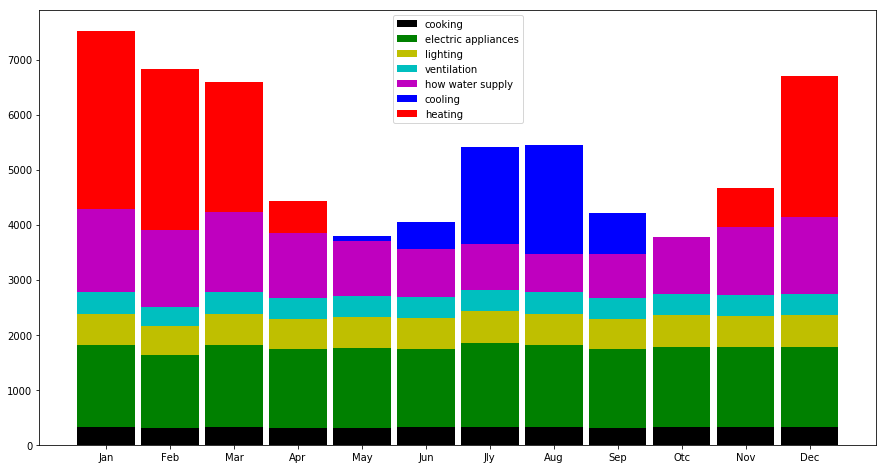

         Jan   Feb   Mar   Apl   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec
暖房      3236  2925  2363   568     0     0     0     0     0     0   704  2573
冷房         0     0     0     0    75   485  1769  1987   748     0     0     0
給湯      1515  1384  1452  1185  1005   875   826   696   800  1036  1237  1390
換気       390   353   390   376   390   376   390   390   376   390   376   390
照明       573   519   573   553   559   553   586   573   553   566   566   566
家電      1477  1338  1477  1425  1443  1425  1512  1477  1425  1460  1460  1460
調理       331   300   331   312   312   323   331   331   312   323   319   323
分解後の合計  7524  6822  6587  4421  3786  4040  5416  5455  4216  3777  4665  6705
分解前     7524  6822  6588  4421  3786  4040  5416  5455  4216  3777  4665  6705


In [78]:
analysis_and_plot({
    'general' : {
        'number_of_people' : 4,
        'main_habitable_room_floor_area' : 29.81,
        'other_habitable_room_floor_area' : 54.34,
        'total_floor_area' : 120.08,
        'calorific_value' : CALORIFIC_V_ELEC,
    },
    'consumption' : [771, 699, 675, 453, 388, 414, 555, 559, 432, 387, 478, 687], 
    'heating' : {
        'use' : [True, True, True, True, False, False, False, False, False, False, True, True]
    },
    'cooling' : {
        'use' : [False, False, False, False, True, True, True, True, True, False, False, False]
    },
    'ventilation' : { 'use' : True, 'coeff' : 1.0 },
    'hot_water_supply' : { 'use' : True, 'coeff' : 1.0 },
    'lighting' : { 'use' : True, 'coeff' : 1.0 },
    'electric_appliance' : { 'use' : True, 'coeff' : 1.0 },
    'cooking' : { 'use' : True, 'coeff' : 1.0 }
})

給湯を除く暖冷房・換気・照明・家電・調理に電力を使用する場合

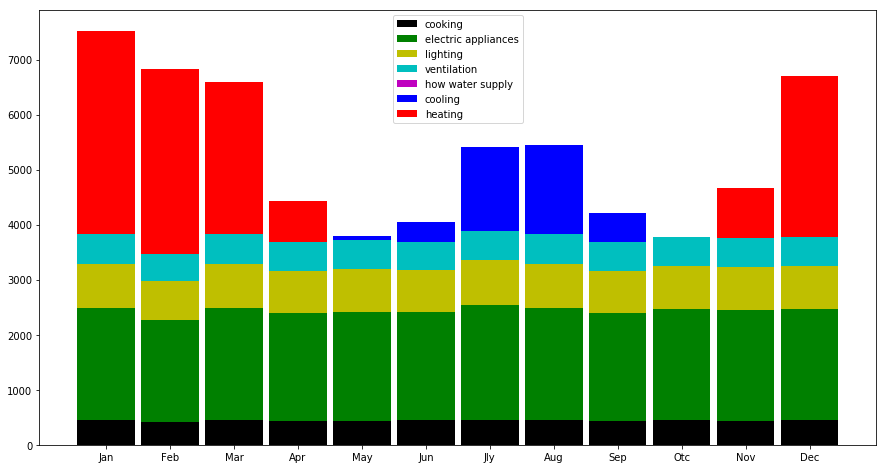

         Jan   Feb   Mar   Apl   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec
暖房      3703  3360  2767   745     0     0     0     0     0     0   912  2928
冷房         0     0     0     0    58   349  1529  1634   540     0     0     0
給湯         0     0     0     0     0     0     0     0     0     0     0     0
換気       537   486   537   518   537   518   537   537   518   537   518   537
照明       790   715   790   762   771   762   808   790   762   780   780   780
家電      2036  1845  2036  1964  1988  1964  2084  2036  1964  2012  2012  2012
調理       456   414   456   429   429   445   456   456   429   445   440   445
分解後の合計  7524  6822  6588  4421  3786  4040  5416  5455  4216  3777  4665  6705
分解前     7524  6822  6588  4421  3786  4040  5416  5455  4216  3777  4665  6705


In [79]:
analysis_and_plot({
    'general' : {
        'number_of_people' : 4,
        'main_habitable_room_floor_area' : 29.81,
        'other_habitable_room_floor_area' : 54.34,
        'total_floor_area' : 120.08,
        'calorific_value' : CALORIFIC_V_ELEC,
    },
#    'consumption' : [7519, 6810, 6588, 4422, 3791, 4032, 5420, 5458, 4212, 3774, 4661, 6705], 
    'consumption' : [771, 699, 675, 453, 388, 414, 555, 559, 432, 387, 478, 687], 
    'heating' : {
        'use' : [True, True, True, True, False, False, False, False, False, False, True, True]
    },
    'cooling' : {
        'use' : [False, False, False, False, True, True, True, True, True, False, False, False]
    },
    'ventilation' : { 'use' : True, 'coeff' : 1.0 },
    'hot_water_supply' : { 'use' : False, 'coeff' : 1.0 },
    'lighting' : { 'use' : True, 'coeff' : 1.0 },
    'electric_appliance' : { 'use' : True, 'coeff' : 1.0 },
    'cooking' : { 'use' : True, 'coeff' : 1.0 },
})

暖房・給湯・調理にガスを使用する場合

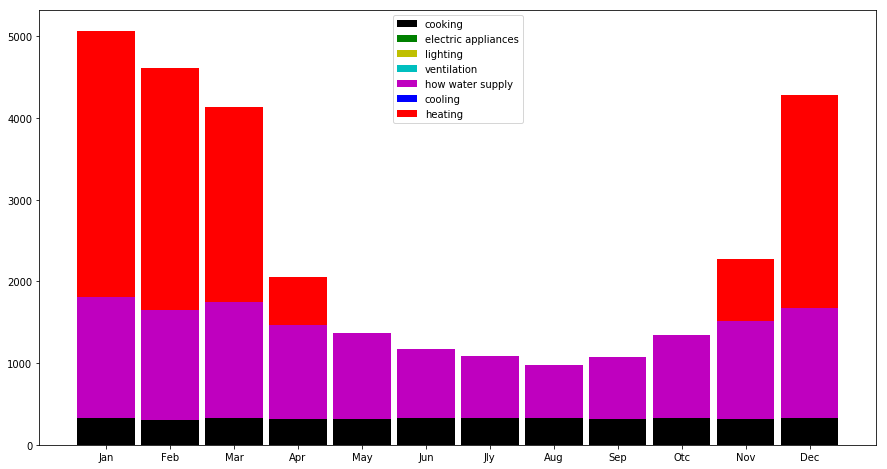

         Jan   Feb   Mar   Apl   May   Jun   Jul  Aug   Sep   Oct   Nov   Dec
暖房      3266  2961  2398   586     0     0     0    0     0     0   753  2602
冷房         0     0     0     0     0     0     0    0     0     0     0     0
給湯      1471  1344  1410  1151  1058   847   751  647   763  1021  1201  1351
換気         0     0     0     0     0     0     0    0     0     0     0     0
照明         0     0     0     0     0     0     0    0     0     0     0     0
家電         0     0     0     0     0     0     0    0     0     0     0     0
調理       331   300   331   312   312   323   331  331   312   323   319   323
分解後の合計  5070  4607  4140  2050  1371  1171  1083  979  1076  1345  2275  4277
分解前     5070  4607  4140  2050  1371  1171  1083  979  1076  1345  2275  4277


In [80]:
analysis_and_plot({
    'general' : {
        'number_of_people' : 4,
        'main_habitable_room_floor_area' : 29.81,
        'other_habitable_room_floor_area' : 54.34,
        'total_floor_area' : 120.08,
        'calorific_value' : 1.0,
    },
    'consumption' : [5070, 4607, 4140, 2050, 1371, 1171, 1083, 979, 1076, 1345, 2275, 4277],
    'heating' : {
        'use' : [True, True, True, True, False, False, False, False, False, False, True, True]
    },
    'cooling' : {
        'use' : [False, False, False, False, False, False, False, False, False, False, False, False]
    },
    'ventilation' : { 'use' : False, 'coeff' : 1.0 },
    'hot_water_supply' : { 'use' : True, 'coeff' : 1.0 },
    'lighting' : { 'use' : False, 'coeff' : 1.0 },
    'electric_appliance' : { 'use' : False, 'coeff' : 1.0 },
    'cooking' : { 'use' : True, 'coeff' : 1.0 }
})

暖房・調理にガスを使用する場合

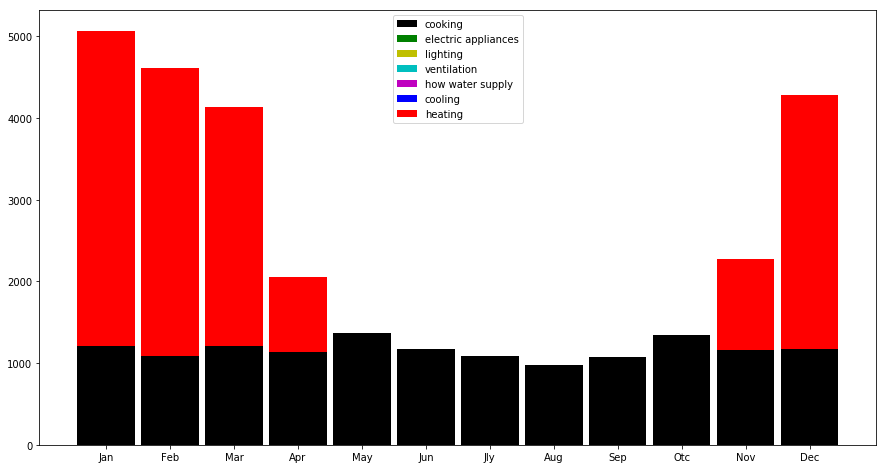

         Jan   Feb   Mar   Apl   May   Jun   Jul  Aug   Sep   Oct   Nov   Dec
暖房      3866  3515  2936   916     0     0     0    0     0     0  1113  3101
冷房         0     0     0     0     0     0     0    0     0     0     0     0
給湯         0     0     0     0     0     0     0    0     0     0     0     0
換気         0     0     0     0     0     0     0    0     0     0     0     0
照明         0     0     0     0     0     0     0    0     0     0     0     0
家電         0     0     0     0     0     0     0    0     0     0     0     0
調理      1203  1091  1203  1133  1371  1171  1083  979  1076  1345  1161  1175
分解後の合計  5070  4607  4140  2050  1371  1171  1083  979  1076  1345  2275  4277
分解前     5070  4607  4140  2050  1371  1171  1083  979  1076  1345  2275  4277


In [81]:
analysis_and_plot({
    'general' : {
        'number_of_people' : 4,
        'main_habitable_room_floor_area' : 29.81,
        'other_habitable_room_floor_area' : 54.34,
        'total_floor_area' : 120.08,
        'calorific_value' : 1.0,
    },
    'consumption' : [5070, 4607, 4140, 2050, 1371, 1171, 1083, 979, 1076, 1345, 2275, 4277],
    'heating' : {
        'use' : [True, True, True, True, False, False, False, False, False, False, True, True]
    },
    'cooling' : {
        'use' : [False, False, False, False, False, False, False, False, False, False, False, False]
    },
    'ventilation' : { 'use' : False, 'coeff' : 1.0 },
    'hot_water_supply' : { 'use' : False, 'coeff' : 1.0 },
    'lighting' : { 'use' : False, 'coeff' : 1.0 },
    'electric_appliance' : { 'use' : False, 'coeff' : 1.0 },
    'cooking' : { 'use' : True, 'coeff' : 1.0 }
})

暖房・給湯に石油を使用する場合

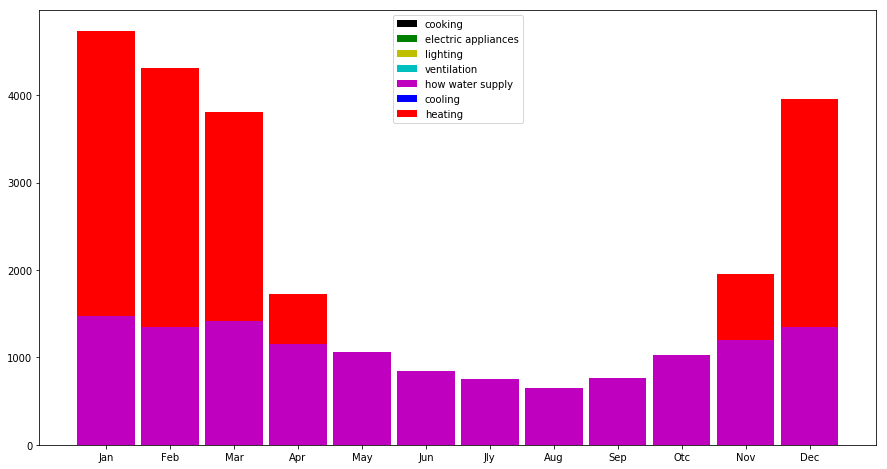

         Jan   Feb   Mar   Apl   May  Jun  Jul  Aug  Sep   Oct   Nov   Dec
暖房      3266  2963  2396   577     0    0    0    0    0     0   752  2603
冷房         0     0     0     0     0    0    0    0    0     0     0     0
給湯      1471  1344  1410  1151  1058  849  751  645  765  1023  1201  1351
換気         0     0     0     0     0    0    0    0    0     0     0     0
照明         0     0     0     0     0    0    0    0    0     0     0     0
家電         0     0     0     0     0    0    0    0    0     0     0     0
調理         0     0     0     0     0    0    0    0    0     0     0     0
分解後の合計  4738  4308  3807  1729  1058  849  751  645  765  1023  1954  3955
分解前     4738  4308  3807  1729  1058  849  751  645  765  1023  1954  3955


In [82]:
analysis_and_plot({
    'general' : {
        'number_of_people' : 4,
        'main_habitable_room_floor_area' : 29.81,
        'other_habitable_room_floor_area' : 54.34,
        'total_floor_area' : 120.08,
        'calorific_value' : 1.0,
    },
    'consumption' : [4738, 4308, 3807, 1729, 1058, 849, 751, 645, 765, 1023, 1954, 3955],
    'heating' : {
        'use' : [True, True, True, True, False, False, False, False, False, False, True, True]
    },
    'cooling' : {
        'use' : [False, False, False, False, False, False, False, False, False, False, False, False]
    },
    'ventilation' : { 'use' : False, 'coeff' : 1.0 },
    'hot_water_supply' : { 'use' : True, 'coeff' : 1.0 },
    'lighting' : { 'use' : False, 'coeff' : 1.0 },
    'electric_appliance' : { 'use' : False, 'coeff' : 1.0 },
    'cooking' : { 'use' : False, 'coeff' : 1.0 }
})

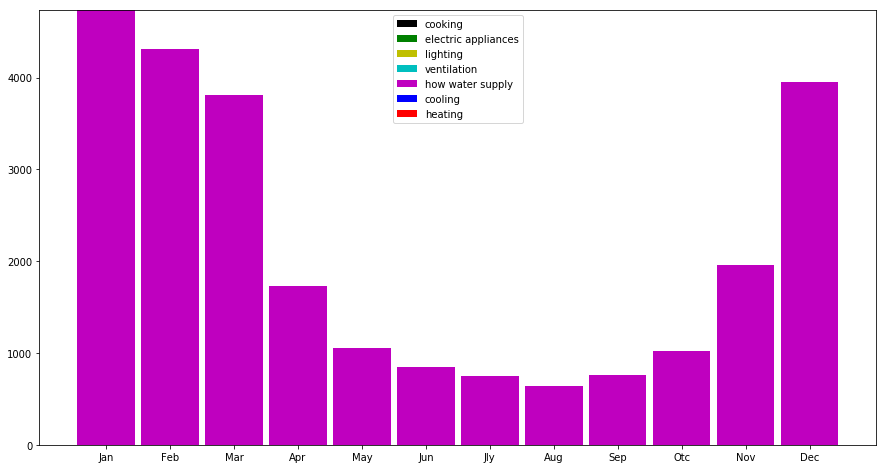

         Jan   Feb   Mar   Apl   May  Jun  Jul  Aug  Sep   Oct   Nov   Dec
暖房         0     0     0     0     0    0    0    0    0     0     0     0
冷房         0     0     0     0     0    0    0    0    0     0     0     0
給湯      4738  4308  3807  1729  1058  849  751  645  765  1023  1954  3955
換気         0     0     0     0     0    0    0    0    0     0     0     0
照明         0     0     0     0     0    0    0    0    0     0     0     0
家電         0     0     0     0     0    0    0    0    0     0     0     0
調理         0     0     0     0     0    0    0    0    0     0     0     0
分解後の合計  4738  4308  3807  1729  1058  849  751  645  765  1023  1954  3955
分解前     4738  4308  3807  1729  1058  849  751  645  765  1023  1954  3955


In [83]:
analysis_and_plot({
    'general' : {
        'number_of_people' : 4,
        'main_habitable_room_floor_area' : 29.81,
        'other_habitable_room_floor_area' : 54.34,
        'total_floor_area' : 120.08,
        'calorific_value' : 1.0,
    },
    'consumption' : [4738, 4308, 3807, 1729, 1058, 849, 751, 645, 765, 1023, 1954, 3955],
    'heating' : {
        'use' : [False, False, False, False, False, False, False, False, False, False, False, False]
    },
    'cooling' : {
        'use' : [False, False, False, False, False, False, False, False, False, False, False, False]
    },
    'ventilation' : { 'use' : False, 'coeff' : 1.0 },
    'hot_water_supply' : { 'use' : True, 'coeff' : 1.0 },
    'lighting' : { 'use' : False, 'coeff' : 1.0 },
    'electric_appliance' : { 'use' : False, 'coeff' : 1.0 },
    'cooking' : { 'use' : False, 'coeff' : 1.0 }
})